# C14-hepatocyte analysis

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [1]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings

%matplotlib inline

mem = joblib.Memory(location='~/tmp/hepato/', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

## Data

In [4]:
data = pd.read_csv('../data/C14data_liver_samples_20191023.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

## Fit the models

In [5]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'].copy(),data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'].copy(),data=edata,step_size=step_size)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [6]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [7]:
models = c14.models.liver.models_list + [c14.models.minimal.POP1]
# models = [c14.models.liver.R]
models

[c14.models.liver.R,
 c14.models.liver.R_kappa_wo_limit,
 c14.models.liver.R_kappa_wo_limit_k42_free,
 c14.models.liver.Rr40,
 c14.models.minimal.POP1]

In [8]:
init_limit = {'r2': (-3, 0), 
              'r2_0': (-3, 0), 
              'r2_100': (-3, 0), 
              'r4': (-3, 0),
              'lambda2': (-3, 0),
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa24_0': (-3, 0),
              'kappa24_100': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [9]:
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [10]:
%%time
results = fit_models(edata, models, step_size=2, 
                     optimize_minuit_multistart_kwargs=dict(n=50, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

Fitting model R
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model R_kappa_wo_limit
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model R_kappa_wo_limit_k42_free
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model Rr40
[(-3, 0), (-3, 0), (-3, 0)]
Multistart found no valid results for model Rr40
Could not calculate errors for Rr40
Fitting model POP1
[(-3, 0)]
CPU times: user 16.6 s, sys: 539 ms, total: 17.1 s
Wall time: 1min 14s


In [16]:
c14.models.liver.Rr40()


Parameters are:
delta2 = 0.1
delta4 = 0.1
kappa42 = 0.01

Implicit Parameters are:
r2 = [0.10320348051650519, 0.1035038631473381, 0.10736100849621451, 0.11774515679486097, 0.1293975599630625]
r4 = [0.0, 0.0, 0.0, 0.0, 0.0]
lambda2 = [0.10889535089817565, 0.11369506572054679, 0.12695977446639486, 0.15519104715557022, 0.18461044843337993]
lambda4 = [0.01, 0.01, 0.01, 0.01, 0.01]
ratio_r = [0.0, 0.0, 0.0, 0.0, 0.0]
ratio_kappa = [1.7568917296857323, 0.9812384679987294, 0.5102362064639713, 0.26705200233381743, 0.18111713183373876]
p2 = [0.9477308228980984, 0.9103637215157795, 0.8456301135335745, 0.7587110142818234, 0.7009221908139072]
p4 = [0.0, 0.0, 0.0, 0.0, 0.0]
f24 = [0.005226917710190157, 0.008963627848422053, 0.015436988646642549, 0.024128898571817662, 0.029907780918609298]
f42 = [0.0008168715032190288, 0.001204543542303599, 0.002123489473709712, 0.0035563293222865056, 0.004583188500509664]
ratio_f = [0.1562816842565732, 0.13438125306771245, 0.13755853050857547, 0.14738879653795164,

In [18]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[20, 50, 80],
                                     samples=1000,
                                    ignore_physics=True)
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [23]:
parameters = summarise(results)
# parameters_young = summarise(results_young)
# parameters_old = summarise(results_old)

In [24]:
parameters[parameters['lower'] > parameters['point_estimate']]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax
9,20,p4,0.758794,0.802108,1.018540,R,-0.043314,0.259746
54,20,p4,0.758794,0.802108,1.018540,R_kappa_wo_limit,-0.043314,0.259746
99,20,p4,0.401670,0.437027,1.153144,R_kappa_wo_limit_k42_free,-0.035357,0.751474


In [25]:
parameters[(parameters['upper'] < parameters['point_estimate'])]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax


## Parameter Values

### Summarized

In [26]:
parameters.query('parameter == "delta2" and time == "20"')

,time,parameter,point_estimate,lower,upper,model,ymin,ymax
0,20,delta2,0.358835,0.281279,0.456988,R,0.077556,0.098153
45,20,delta2,0.358835,0.281279,0.456988,R_kappa_wo_limit,0.077556,0.098153
90,20,delta2,0.439647,0.290183,0.661377,R_kappa_wo_limit_k42_free,0.149464,0.221730


NameError: name 'time_data' is not defined

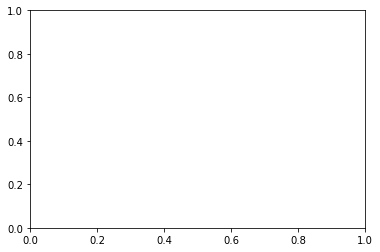

In [27]:
fig, ax = plt.subplots()
data = parameters[parameters['parameter'] == 'delta2']

ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
            data=time_data, marker='o', ls='None', label=time)
ax.legend()
ax.set_ylabel(parameter)
#     try:
#         ax.set_ylim(ylimits[parameter])
#     except:
# ylim = ax.get_ylim()
# ax.set_ylim(max(ylim[0], 0), ylim[1])
ax.tick_params(axis='x', labelrotation=45)

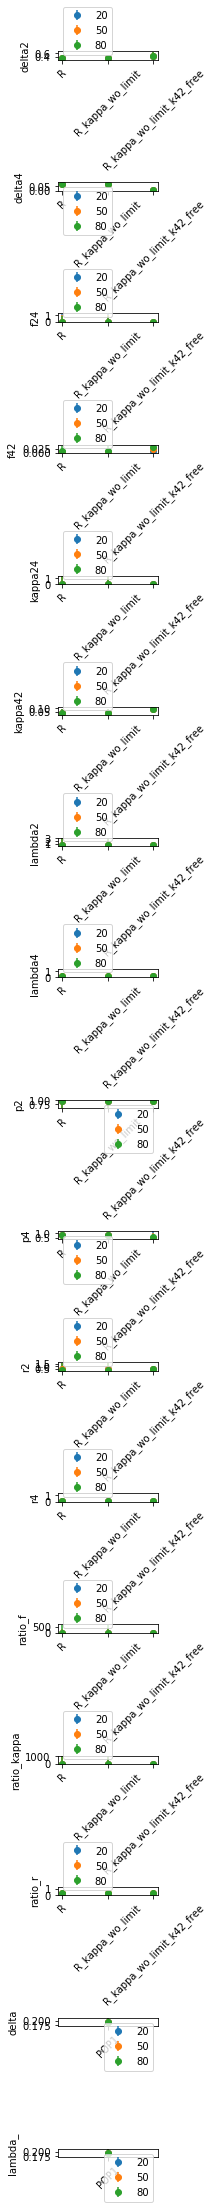

In [28]:
p_names = parameters['parameter'].unique()
# paras = [parameters, parameters_young, parameters_old]

fig, axs = plt.subplots(len(p_names), 1, figsize=(3, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.5),
           'kappa42': (0, 1.15),
          'ratio_kappa': (0, 10)}

for parameter, ax in zip(p_names, axs):
    data = parameters[parameters['parameter'] == parameter]
    for time, time_data in data.groupby('time'):
        ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                    data=time_data, marker='o', ls='None', label=time)
        ax.legend()
        ax.set_ylabel(parameter)
#     try:
#         ax.set_ylim(ylimits[parameter])
#     except:
    ylim = ax.get_ylim()
    ax.set_ylim(max(ylim[0], 0), ylim[1])
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

### Detailed

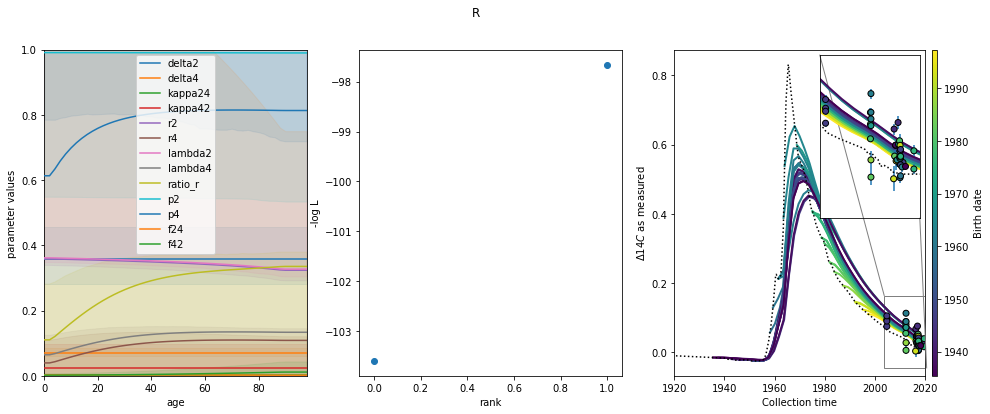

point_estimate        lower      upper
time parameter                                         
0    delta2            0.358835     0.281279   0.456988
     delta4           0.0709616    0.0592542  0.0856492
     f24             0.00303639  9.77864e-06    1.27158
     f42             0.00203505  0.000568697  0.0078401
     kappa24         0.00330649  1.06485e-05    1.38469
     kappa42          0.0249127   0.00696189  0.0959771
     lambda2           0.361633     0.347318    3.08886
     lambda4          0.0644192     -30.9231   0.123963
     p2                0.990857     0.549026   0.999975
     p4                0.613271     0.785188    1.02419
     r2                0.358326     0.338419    1.69743
     r4               0.0395064      -30.987   0.108853
     ratio_f            0.67022   0.00376104    89.0655
     ratio_kappa         7.5345    0.0422809    1001.26
     ratio_r           0.110253     -18.3632   0.281404
50   delta2            0.358835     0.281279   0.456988
     delta4           0.0709616    0.0592542  0.0856492
     f24             0.00260436  8.38729e-06    1.09065
     f42             0.00529019   0.00147835  0.0203806
     kappa24         0.00330649  1.06485e-05    1.38469
     kappa42          0.0249127   0.00696189  0.0959771
     lambda2            0.34919     0.333786    3.07083
     lambda4           0.131651     -10.0451   0.150372
     p2                0.990531     0.546069   0.999975
     p4                0.810766     0.782867    1.01823
     r2                0.345883     0.322528    1.68106
     r4                0.106738      -10.109   0.130603
     ratio_f            2.03129    0.0113988    269.937
     ratio_kappa         7.5345    0.0422809    1001.26
     ratio_r           0.308595     -6.06901   0.370471
80   delta2            0.358835     0.281279   0.456988
     delta4           0.0709616    0.0592542  0.0856492
     f24             0.00201545  6.49072e-06   0.844028
     f42             0.00972734   0.00271831  0.0374749
     kappa24         0.00330649  1.06485e-05    1.38469
     kappa42          0.0249127   0.00696189  0.0959771
     lambda2           0.334252     0.313495    3.04441
     lambda4            0.13425     -4.10774    0.14594
     p2                0.990108     0.539617   0.999974
     p4                0.814431      0.74701    1.01708
     r2                0.330946       0.3015    1.65808
     r4                0.109338     -4.17159   0.122389
     ratio_f            4.82639     0.027084    641.378
     ratio_kappa         7.5345    0.0422809    1001.26
     ratio_r           0.330379     -2.55692   0.374584
100  delta2            0.358835     0.281279   0.456988
     delta4           0.0709616    0.0592542  0.0856492
     f24             0.00179106  5.76808e-06    0.75006
     f42               0.011418   0.00319077  0.0439881
     kappa24         0.00330649  1.06485e-05    1.38469
     kappa42          0.0249127   0.00696189  0.0959771
     lambda2           0.327015     0.303428    3.03081
     lambda4           0.133482     -3.06082   0.144033
     p2                0.989889     0.534223   0.999974
     p4                0.813363      0.71903    1.01735
     r2                0.323708     0.291281    1.63098
     r4                0.108569     -3.12467   0.119758
     ratio_f            6.37498    0.0357741     847.17
     ratio_kappa         7.5345    0.0422809    1001.26
     ratio_r           0.335392     -1.93106   0.379448

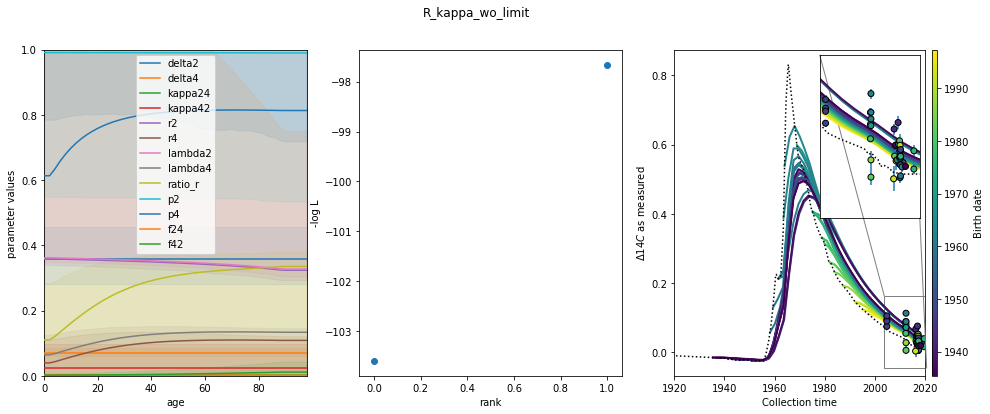

point_estimate        lower      upper
time parameter                                         
0    delta2            0.358835     0.281279   0.456988
     delta4           0.0709616    0.0592542  0.0856492
     f24             0.00303639  9.77864e-06    1.27158
     f42             0.00203505  0.000568697  0.0078401
     kappa24         0.00330649  1.06485e-05    1.38469
     kappa42          0.0249127   0.00696189  0.0959771
     lambda2           0.361633     0.347318    3.08886
     lambda4          0.0644192     -30.9231   0.123963
     p2                0.990857     0.549026   0.999975
     p4                0.613271     0.785188    1.02419
     r2                0.358326     0.338419    1.69743
     r4               0.0395064      -30.987   0.108853
     ratio_f            0.67022   0.00376104    89.0655
     ratio_kappa         7.5345    0.0422809    1001.26
     ratio_r           0.110253     -18.3632   0.281404
50   delta2            0.358835     0.281279   0.456988
     delta4           0.0709616    0.0592542  0.0856492
     f24             0.00260436  8.38729e-06    1.09065
     f42             0.00529019   0.00147835  0.0203806
     kappa24         0.00330649  1.06485e-05    1.38469
     kappa42          0.0249127   0.00696189  0.0959771
     lambda2            0.34919     0.333786    3.07083
     lambda4           0.131651     -10.0451   0.150372
     p2                0.990531     0.546069   0.999975
     p4                0.810766     0.782867    1.01823
     r2                0.345883     0.322528    1.68106
     r4                0.106738      -10.109   0.130603
     ratio_f            2.03129    0.0113988    269.937
     ratio_kappa         7.5345    0.0422809    1001.26
     ratio_r           0.308595     -6.06901   0.370471
80   delta2            0.358835     0.281279   0.456988
     delta4           0.0709616    0.0592542  0.0856492
     f24             0.00201545  6.49072e-06   0.844028
     f42             0.00972734   0.00271831  0.0374749
     kappa24         0.00330649  1.06485e-05    1.38469
     kappa42          0.0249127   0.00696189  0.0959771
     lambda2           0.334252     0.313495    3.04441
     lambda4            0.13425     -4.10774    0.14594
     p2                0.990108     0.539617   0.999974
     p4                0.814431      0.74701    1.01708
     r2                0.330946       0.3015    1.65808
     r4                0.109338     -4.17159   0.122389
     ratio_f            4.82639     0.027084    641.378
     ratio_kappa         7.5345    0.0422809    1001.26
     ratio_r           0.330379     -2.55692   0.374584
100  delta2            0.358835     0.281279   0.456988
     delta4           0.0709616    0.0592542  0.0856492
     f24             0.00179106  5.76808e-06    0.75006
     f42               0.011418   0.00319077  0.0439881
     kappa24         0.00330649  1.06485e-05    1.38469
     kappa42          0.0249127   0.00696189  0.0959771
     lambda2           0.327015     0.303428    3.03081
     lambda4           0.133482     -3.06082   0.144033
     p2                0.989889     0.534223   0.999974
     p4                0.813363      0.71903    1.01735
     r2                0.323708     0.291281    1.63098
     r4                0.108569     -3.12467   0.119758
     ratio_f            6.37498    0.0357741     847.17
     ratio_kappa         7.5345    0.0422809    1001.26
     ratio_r           0.335392     -1.93106   0.379448

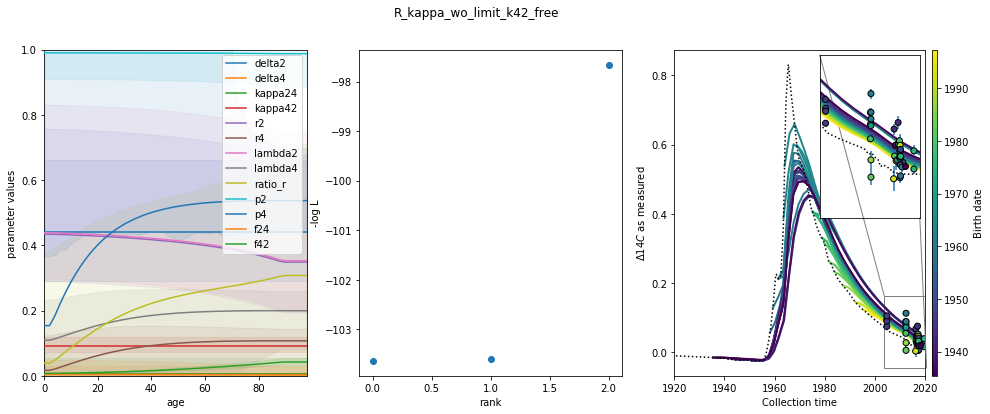

point_estimate        lower       upper
time parameter                                          
0    delta2            0.439647     0.290183    0.661377
     delta4          0.00458872  0.000763676   0.0292968
     f24             0.00400908  0.000290359   0.0492958
     f42             0.00754712   0.00596633  0.00972569
     kappa24          0.0043657  0.000316188   0.0536808
     kappa42          0.0923905    0.0730388     0.11906
     lambda2           0.438561     0.296788    0.831012
     lambda4           0.109187    -0.978005    0.232533
     p2                0.990045     0.910397    0.999192
     p4                0.153831     0.366495     1.19177
     r2                0.434196     0.290269    0.757295
     r4               0.0167964     -1.05738    0.124346
     ratio_f            1.88251     0.152857     27.5182
     ratio_kappa        21.1628      1.71839     309.355
     ratio_r          0.0386839     -1.99622    0.380039
50   delta2            0.439647     0.290183    0.661377
     delta4          0.00458872  0.000763676   0.0292968
     f24             0.00343865  0.000249046   0.0422818
     f42               0.019619    0.0155097   0.0252823
     kappa24          0.0043657  0.000316188   0.0536808
     kappa42          0.0923905    0.0730388     0.11906
     lambda2           0.413929     0.270542    0.809233
     lambda4           0.192376    -0.161435    0.266849
     p2                0.989453     0.905313    0.999116
     p4                0.519739     0.414566     1.03572
     r2                0.409563     0.264431    0.731984
     r4               0.0999851    -0.251106    0.153225
     ratio_f            5.70545     0.463274     83.4014
     ratio_kappa        21.1628      1.71839     309.355
     ratio_r           0.244126    -0.502607    0.553574
80   delta2            0.439647     0.290183    0.661377
     delta4          0.00458872  0.000763676   0.0292968
     f24             0.00266108   0.00019273   0.0327208
     f42              0.0360745    0.0285185   0.0464878
     kappa24          0.0043657  0.000316188   0.0536808
     kappa42          0.0923905    0.0730388     0.11906
     lambda2           0.373959      0.22458    0.769051
     lambda4           0.199526     0.047981    0.261123
     p2                0.988326     0.893508     0.99895
     p4                 0.53695     0.430305    0.739156
     r2                0.369593     0.217391    0.697374
     r4                0.107135   -0.0380125    0.146433
     ratio_f            13.5563      1.10075     198.164
     ratio_kappa        21.1628      1.71839     309.355
     ratio_r           0.289874   -0.0739812    0.658794
100  delta2            0.439647     0.290183    0.661377
     delta4          0.00458872  0.000763676   0.0292968
     f24             0.00236482  0.000171273   0.0290779
     f42              0.0423443    0.0334751   0.0545676
     kappa24          0.0043657  0.000316188   0.0536808
     kappa42          0.0923905    0.0730388     0.11906
     lambda2           0.352852     0.198084    0.748688
     lambda4           0.199561    0.0828603    0.259733
     p2                0.987627     0.884985    0.998868
     p4                0.537031     0.450124    0.697289
     r2                0.348487     0.194348    0.679432
     r4                0.107171  -0.00243037    0.144364
     ratio_f             17.906      1.45394     261.747
     ratio_kappa        21.1628      1.71839     309.355
     ratio_r           0.307531  -0.00871211    0.708437

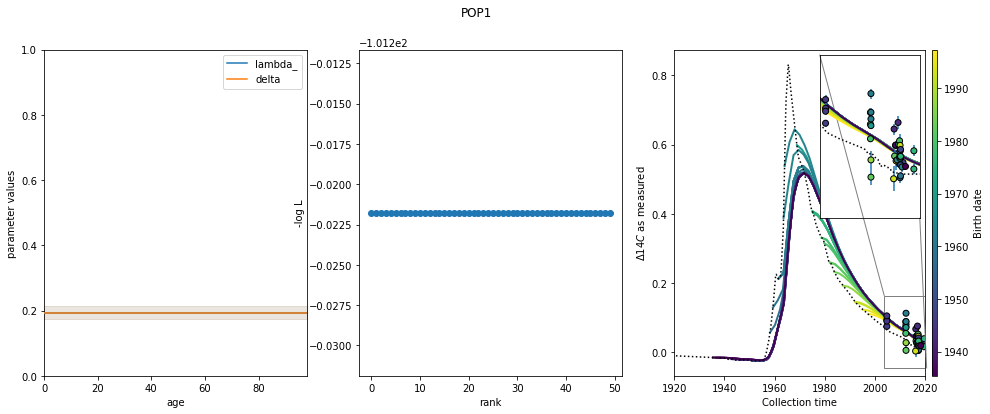

point_estimate     lower    upper
time parameter                                  
0    delta           0.192362  0.172864  0.21444
     lambda_         0.192362  0.172864  0.21444
50   delta           0.192362  0.172864  0.21444
     lambda_         0.192362  0.172864  0.21444
80   delta           0.192362  0.172864  0.21444
     lambda_         0.192362  0.172864  0.21444
100  delta           0.192362  0.172864  0.21444
     lambda_         0.192362  0.172864  0.21444

In [29]:
for name, result in results.items():
    if name not in ['']:
        no_plot = ['ratio_kappa', 'ratio_f']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80, 100], ignore_physics=True
                                               ))
        except:
            pass

## Export

In [ ]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [ ]:
# _ = results.pop('POP1', None)

In [ ]:
model_selection_results = pd.DataFrame(
    pd.Series(
        {name: result['op'].calc_aicc(result['point_estimate'])
         for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

In [ ]:
# parameters = parameters.merge(model_selection_results, left_on='model', right_index=True)

In [ ]:
# parameters['log10_point_estimate'] = np.log10(parameters['point_estimate'])
# parameters['log10_lower'] = np.log10(parameters['lower'])
# parameters['log10_upper'] = np.log10(parameters['upper'])
# parameters.head()

# parameters['log10_error_lower'] = parameters['log10_point_estimate'] - parameters['log10_lower']
# parameters['log10_error_upper'] = -parameters['log10_point_estimate'] + parameters['log10_upper']

# parameters['log10_error'] = parameters[['log10_error_lower', 'log10_error_upper']].mean(axis='columns')

# parameters.head()

# def parameter_average(data):
#     parameter = data['parameter'].iloc[0]
#     log10_mean = np.average(data['log10_point_estimate'], weights=data['w'])
#     log10_error = np.average(
#         np.sqrt(data['log10_error']**2 + (data['log10_point_estimate'] - log10_mean)**2),
#         weights=data['w'])
#     point_estimate = 10**log10_mean
#     lower = 10**(log10_mean-log10_error)
#     upper = 10**(log10_mean+log10_error)
#     return pd.Series({
#         'point_estimate': point_estimate,
#         'lower': lower,
#         'upper': upper,
#         'model': 'average',
#         'ymin': point_estimate - lower,
#         'ymax': point_estimate + upper,
#         'log10_point_estimate': log10_mean,
#         'log10_error': log10_error
#     })

# rates = ["r2", "r4", "delta2", "delta4", "kappa24", "kappa42", "lambda2", "lambda4"]

# averaged_parameters = (parameters
#                        .query('parameter in @rates')
#                        .groupby(['time', 'parameter'])
#                        .apply(parameter_average)
#                        .reset_index()
#                         )

In [ ]:
# parameters = pd.concat([parameters, averaged_parameters], axis='rows', sort=False)

In [ ]:
# p_names = parameters['parameter'].unique()
# paras = 3*[parameters]
# fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



# ylimits = {'delta2': (0, 2),
#            'delta4': (0, 1),
#            'lambda2': (0, 2),
#            'r2': (0, 2),
#            'p2': (0.5, 1.1),
#            'p4': (0.5, 1.1),
#            'kappa24': (0, 0.2),
#           'ratio_kappa': (0, 10)}

# for parameter, axs in zip(p_names, axss):
#     for para, ax in zip(paras, axs):
#         data = para[para['parameter'] == parameter]
#         for time, time_data in data.groupby('time'):
#             ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
#                         data=time_data, marker='o', ls='None', label=time)
#             ax.legend()
#             ax.set_ylabel(parameter)
#         try:
#             ax.set_ylim(ylimits[parameter])
#         except:
#             ax.set_ylim(0, 1)
#         ax.tick_params(axis='x', labelrotation=45)

# plt.tight_layout()
# plt.show()